# Tutorial Part 3: Annealed Sequential-Monte-Carlo Sampler

![](figures/smcs_nvi.png)

## Introduction

In this tutorial we using inference combinators to implement a Sequential Monte Carlo Sampler [(Del Moral et al., 2006)](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-9868.2006.00553.x) that generates samples along a geometric annealing path 

\begin{align}
    \gamma_k(x; \beta_k) := q_1(x)^{(1-\beta_k)}\gamma(x)^{\beta_k}
    ,&&
    \beta_1 = 0
    ,&&
    \beta_k \in [0, 1]
    ,&&
    \beta_K = 1,
\end{align}

as outlined in [Zimmermann et al.](https://proceedings.neurips.cc/paper/2021/file/ab49b208848abe14418090d95df0d590-Paper.pdf). 
At each step $k$ we are given approximate samples $x_{k-1}$ from the last target $\gamma_{k-1}$ and use a variational proposals $q_k(\cdot \mid x_{k-1})$ to generate proposals $x_k$ for the next target density $\gamma_k$. We use these proposals to compute an importance weights

\begin{align}
    w_1 = 1
    ,&& 
    w_k = \frac{r_{k-1}(x_{k-1} \mid x_k)\gamma_k(x_k)}{\gamma_{k-1}(x_{k-1})q_k(x_k \mid x_{k-1})}
    && \text{for}\ 1<k\leq K
    ,
\end{align}

which we can use to resample our particles in order to get approximate samples for the next target distribution $\gamma_k$. 

While this sampling strategy is always valid, the quality of the sampler crucially depends on the variance of the importance weight above. The variance of the importance weights $w_k$ is minimized when 

\begin{align}
    \check \gamma_k(x_{k-1}, x_k) 
    := 
    r_{k-1}(x_{k-1} \mid x_k)\gamma_k(x_k)
    &&
    \text{and}\
    &&
    \hat \gamma_k(x_{k-1}, x_k) 
    := 
    \gamma_{k-1}(x_{k-1})q_k(x_k \mid x_{k-1})
\end{align}

are equal. To make $\hat \gamma_k$ as similar as possible to $\check\gamma_k$, we model the variational proposals $q_k$ and reverse kernels $r_k$ as variational distribution with parameters $\phi$ and $\theta$ respectively and minimize a KL-divergence

\begin{align}
\mathcal{D}_{\mathrm{KL}}(\hat\gamma_{k} \mid \check \gamma_{k})
=
\mathbb{E}_{\hat\gamma_{k}(x_{k-1}, x_{k}; \phi, \beta_{k-1})}
\left[
    \log \frac{\hat \gamma_k(x_{k-1}, x_k; \phi, \beta_{k-1})}{\check\gamma_k(x_{k-1}, x_k; \theta, \beta_{k})}
\right]
\end{align}

at each step. We additionally learn the parameters of the schedule of the annealing path $\beta_k$ (for $1<k<K$). Note that the optimization problem in this setting is underconstrained, however, the additional degrees of freedom might be helpful to make intermediate densities, between which the variational proposals struggle to map, close together and vice versa. For a more detailed exposition we refer to [Zimmermann et al.](https://proceedings.neurips.cc/paper/2021/file/ab49b208848abe14418090d95df0d590-Paper.pdf).


## Defining the target and proposal density

We first define our target density which is an unnormalized gaussian mixture with $M=8$ modes, equally spaced around a circle with radius $10$ around the origin. Our initial proposal is Normal with zero mean and standard deviation $5$. 

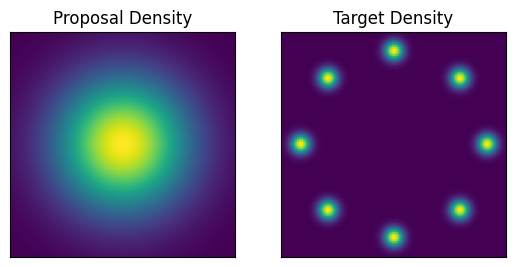

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import flax
import flax.linen as nn
import numpyro.distributions as dist
import numpyro

numpyro.set_platform("cpu")


def ring_gmm_log_density(x, M):
  angles = 2 * jnp.arange(1, M + 1) * jnp.pi / M
  mu = 10 * jnp.stack([jnp.sin(angles), jnp.cos(angles)], -1)
  sigma = jnp.sqrt(0.5)
  return nn.logsumexp(
      dist.Normal(mu, sigma).log_prob(x[..., None, :]).sum(-1), -1
  )


def proposal_log_density(x):
  return dist.Normal(0, 5).log_prob(x).sum(-1)


xrange = np.linspace(-12, 12, 100)
m_xy = np.dstack(np.meshgrid(xrange, xrange))
m_target = np.exp(ring_gmm_log_density(m_xy, M=8))
m_proposal = np.exp(proposal_log_density(m_xy))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.set_title("Proposal Density")
ax1.imshow(m_proposal)
xax1, yax1 = ax1.axes.get_xaxis(), ax1.axes.get_yaxis()
xax1.set_visible(False)
yax1.set_visible(False)
ax2.set_title("Target Density")
ax2.imshow(m_target)
xax2, yax2 = ax2.axes.get_xaxis(), ax2.axes.get_yaxis()
xax2.set_visible(False)
yax2.set_visible(False)

## Defining a Sequence of annealed intermediate densities

Given the proposal and target densities defined above, we can define our intermediate annealed densities using flax. Note that we are defining the tunable parameters `beta_raw` in log space and normalize them appropriately to be in the interval $[0, 1]$.

In [2]:
class AnnealedDensity(nn.Module):
  M = 8

  @nn.compact
  def __call__(self, x, index=0):
    beta_raw = self.param("beta_raw", lambda _: -jnp.ones(self.M - 2))
    beta = nn.sigmoid(
        beta_raw[0] + jnp.pad(jnp.cumsum(nn.softplus(beta_raw[1:])), (1, 0))
    )
    beta = jnp.pad(beta, (1, 1), constant_values=(0, 1))
    beta_k = beta[index]

    target_density = ring_gmm_log_density(x, self.M)
    init_proposal = proposal_log_density(x)
    return beta_k * target_density + (1 - beta_k) * init_proposal

## Network

We now define our variational kernels, which each consist of a two-layer MLP with Relu activations. We additionally define a helper class `VariationalKernelList`, which gives us convenient access to the individual variational kernels (automatically selecting the correct set of parameters), by providing the corresponding index. Lastly we define a `Network` class which wraps around the annealed target, forward kernels, and reverse kernels. This is convenient as it lets us pass around a single object which gives us access to the network of our individual model components.

In [3]:
class VariationalKernelNetwork(nn.Module):

  @nn.compact
  def __call__(self, x):
    h = nn.Dense(50)(x)
    h = nn.relu(h)
    loc = nn.Dense(2, kernel_init=nn.initializers.zeros)(h) + x
    scale_raw = nn.Dense(2, kernel_init=nn.initializers.zeros)(h)
    return loc, nn.softplus(scale_raw)


class VariationalKernelNetworks(nn.Module):
  M = 8

  @nn.compact
  def __call__(self, x, index=0):
    if self.is_mutable_collection('params'):
      vmap_net = nn.vmap(
          VariationalKernelNetwork,
          variable_axes={'params': 0},
          split_rngs={'params': True},
      )
      out = vmap_net(name='kernel')(
          jnp.broadcast_to(x, (self.M - 1,) + x.shape)
      )
      return jax.tree_util.tree_map(lambda x: x[index], out)
    params = self.scope.get_variable('params', 'kernel')
    params_i = jax.tree_util.tree_map(lambda x: x[index], params)
    return VariationalKernelNetwork(name='kernel').apply(
        flax.core.freeze({'params': params_i}), x
    )


class Networks(nn.Module):

  def setup(self):
    self.forward_kernel_params = VariationalKernelNetworks()
    self.reverse_kernel_params = VariationalKernelNetworks()
    self.anneal_density = AnnealedDensity()

  def __call__(self, x):
    self.reverse_kernel_params(x)
    self.anneal_density(x)
    return self.forward_kernel_params(x)

## Defining the model components

With all of our network definitions in place we can now define our model components as probabilistic programs in numpyro.

In [4]:
def anneal_target(network, k=0):
  x = numpyro.sample("x", dist.Normal(0, 5).expand([2]).mask(False).to_event())
  # numpyro.factor("anneal_density", network.anneal_density(x, index=k))
  numpyro.sample(
      "anneal_density", dist.Unit(network.anneal_density(x, index=k))
  )
  return ({"x": x},)


def anneal_forward(network, inputs, k=0):
  mu, sigma = network.forward_kernel_params(inputs["x"], index=k)
  return numpyro.sample("x", dist.Normal(mu, sigma).to_event(1))


def anneal_reverse(network, inputs, k=0):
  mu, sigma = network.reverse_kernel_params(inputs["x"], index=k)
  return numpyro.sample("x", dist.Normal(mu, sigma).to_event(1))

## Using predefined inference algorithms in coix

Coix already implements a selection of inference algorithms including Nested Variational Inference (NVI). All we need to do is to instantiate our model components and pass it to the method that composes the inference program for us. 

In [5]:
from functools import partial
import jax
from jax import random
import coix

coix.set_backend("coix.numpyro")


def make_anneal(params, unroll=False, num_particles=10, num_targets=8):
  network = coix.util.BindModule(Networks(), params)
  # Add particle dimension and construct a program.
  make_particle_plate = lambda: numpyro.plate("particle", num_particles, dim=-1)
  targets = lambda k: make_particle_plate()(
      partial(anneal_target, network, k=k)
  )
  forwards = lambda k: make_particle_plate()(
      partial(anneal_forward, network, k=k)
  )
  reverses = lambda k: make_particle_plate()(
      partial(anneal_reverse, network, k=k)
  )
  if unroll:  # to unroll the algorithm, we provide a list of programs
    targets = [targets(k) for k in range(num_targets)]
    forwards = [forwards(k) for k in range(num_targets - 1)]
    reverses = [reverses(k) for k in range(num_targets - 1)]
  program = coix.algo.nvi_rkl(
      targets, forwards, reverses, num_targets=num_targets
  )
  return program

## Evaluating the untrained model

As mentioned before, while our sampler might not be very efficient before we train it, it is still valid. So let's see how our sampler performs pre-training first.

{'ess': 16678.6855, 'log_Z': 2.0389, 'log_density': -3.656, 'loss': 12.3431}


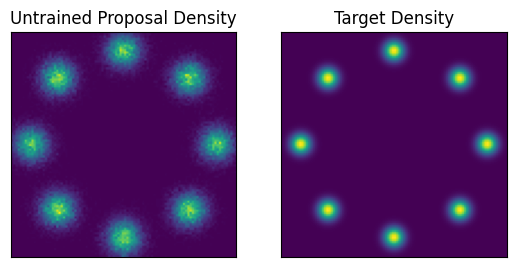

In [6]:
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Ellipse, Rectangle


def eval_program(seed, params, num_particles):
  with numpyro.handlers.seed(rng_seed=seed):
    p = make_anneal(params, unroll=True, num_particles=num_particles)
    out, trace, metrics = coix.traced_evaluate(p)()
  return out, trace, metrics


anneal_net = Networks()
init_params = anneal_net.init(random.PRNGKey(0), jnp.zeros(2))
_, trace, metrics = eval_program(
    random.PRNGKey(1), init_params, num_particles=100000
)

metrics.pop("log_weight")
anneal_metrics = jax.tree_util.tree_map(
    lambda x: round(float(jnp.mean(x)), 4), metrics
)
print(anneal_metrics)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
x = trace["x"]["value"].reshape((-1, 2))
H, xedges, yedges = np.histogram2d(
    x[:, 0], x[:, 1], range=[[-12, 12], [-12, 12]], bins=100
)
ax1.set_title("Untrained Proposal Density")
ax1.imshow(H.T)
xax1, yax1 = ax1.axes.get_xaxis(), ax1.axes.get_yaxis()
xax1.set_visible(False)
yax1.set_visible(False)
ax2.set_title("Target Density")
ax2.imshow(m_target)
xax2, yax2 = ax2.axes.get_xaxis(), ax2.axes.get_yaxis()
xax2.set_visible(False)
yax2.set_visible(False)

While visually the samples loosely approximate the target density we can clearly see that the modes are too wide and not tightly enough peaked. This is also reflected in the statistics that we can access in the metics dictionary returned by the evaluation effect handler. We can see that the ess is around $300$ when taking $1000$ samples.

## Training

So let's see if we can do better by training our model with NVI. All we need to do is to repeatedly run our inference program, differentiate the resulting loss, and take a gradient step. `coix.util.train` provides a convenient wrapper for such a training loop and optionally compiles the training procedure.

In [7]:
import optax


def loss_fn(params, key, num_particles, unroll=False):
  # Run the program and get metrics.
  program = make_anneal(params, num_particles=num_particles, unroll=unroll)
  with numpyro.handlers.seed(rng_seed=key):
    _, _, metrics = coix.traced_evaluate(program)()
  return metrics["loss"], metrics


optimizer = optax.adam(1e-3)
num_steps = 50000
num_particles = 36
unroll = True

trained_params, metrics = coix.util.train(
    partial(loss_fn, num_particles=num_particles, unroll=unroll),
    init_params,
    optimizer,
    num_steps,
    jit_compile=True,
)

Compiling the first train step...
Time to compile a train step: 7.7709901332855225
=====
Step 2500  | ess    25.2412 | log_Z     1.2350 | log_density    -3.7176 | loss     0.9471
Step 5000  | ess    31.7915 | log_Z     2.5552 | log_density    -2.5793 | loss     0.6548
Step 7500  | ess    31.3730 | log_Z     1.9925 | log_density    -2.5403 | loss     0.8958
Step 10000 | ess    31.2693 | log_Z     1.4725 | log_density    -3.0077 | loss     0.8856
Step 12500 | ess    32.1133 | log_Z     2.1890 | log_density    -2.0786 | loss     1.3447
Step 15000 | ess    33.2006 | log_Z     1.8315 | log_density    -2.8067 | loss     0.7987
Step 17500 | ess    34.6039 | log_Z     2.0502 | log_density    -2.1592 | loss     1.7737
Step 20000 | ess    34.3501 | log_Z     2.1727 | log_density    -2.1159 | loss     1.5451
Step 22500 | ess    34.5807 | log_Z     2.2028 | log_density    -2.1809 | loss     1.5018
Step 25000 | ess    35.5768 | log_Z     2.3687 | log_density    -2.0594 | loss     1.4789
Step 27500 

While the training loss with only 36 particles is not very informative to assess convergence, we can see that the ess goes up to about $34$ which is a good indicator that we learned a good proposal.

## Evaluate trained model
We already implemented an evaluation wrapped, so let's evaluate the model again but this time with the optimized parameters.

{'ess': 95545.7578, 'log_Z': 2.0781, 'log_density': -2.1964, 'log_weight': 2.0639, 'loss': 1.5768}


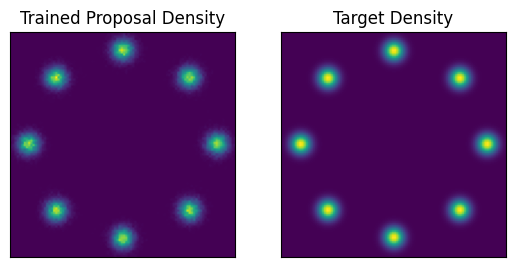

In [8]:
_, trace, metrics = eval_program(
    random.PRNGKey(1), trained_params, num_particles=100000
)

anneal_metrics = jax.tree_util.tree_map(
    lambda x: round(float(jnp.mean(x)), 4), metrics
)
print(anneal_metrics)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
x = trace["x"]["value"].reshape((-1, 2))
m_proposal, _, _ = np.histogram2d(
    x[:, 0], x[:, 1], range=[[-12, 12], [-12, 12]], bins=100
)
ax1.set_title("Trained Proposal Density")
ax1.imshow(m_proposal.T)
xax1, yax1 = ax1.axes.get_xaxis(), ax1.axes.get_yaxis()
xax1.set_visible(False)
yax1.set_visible(False)
ax2.set_title("Target Density")
ax2.imshow(m_target)
xax2, yax2 = ax2.axes.get_xaxis(), ax2.axes.get_yaxis()
xax2.set_visible(False)
yax2.set_visible(False)